In [6]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage
import skimage.io
import sys
import pandas as pd
import pycocotools.mask as RLE
import seaborn as sns


## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/tuning/'
sys.path.append(root)

from AMPIS import data_utils, visualize, analyze, export_anno
from AMPIS.applications import powder
from AMPIS.structures import InstanceSet
from AMPIS.visualize import display_iset


In [3]:

#CONSTANTS
#--------------------------------------------------------------
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
NUM_ITERATIONS = 5000
CHECKPOINT_NUM = 5000
NUM_CYCLES = 1
OUTPUT_FOLDER = 'batch_temp1'
LR = 0.001
WD = 0.0001
BB = 'ResNet50'
#--------------------------------------------------------------


In [4]:
##LOADING DATA
json_path_train = Path('SALAS_Rep', 'images', 'solar_trainingV2.json')  # path to training data
json_path_val = Path('SALAS_Rep', 'images', 'solar_validV2.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

## REGISTERING DATA

DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data

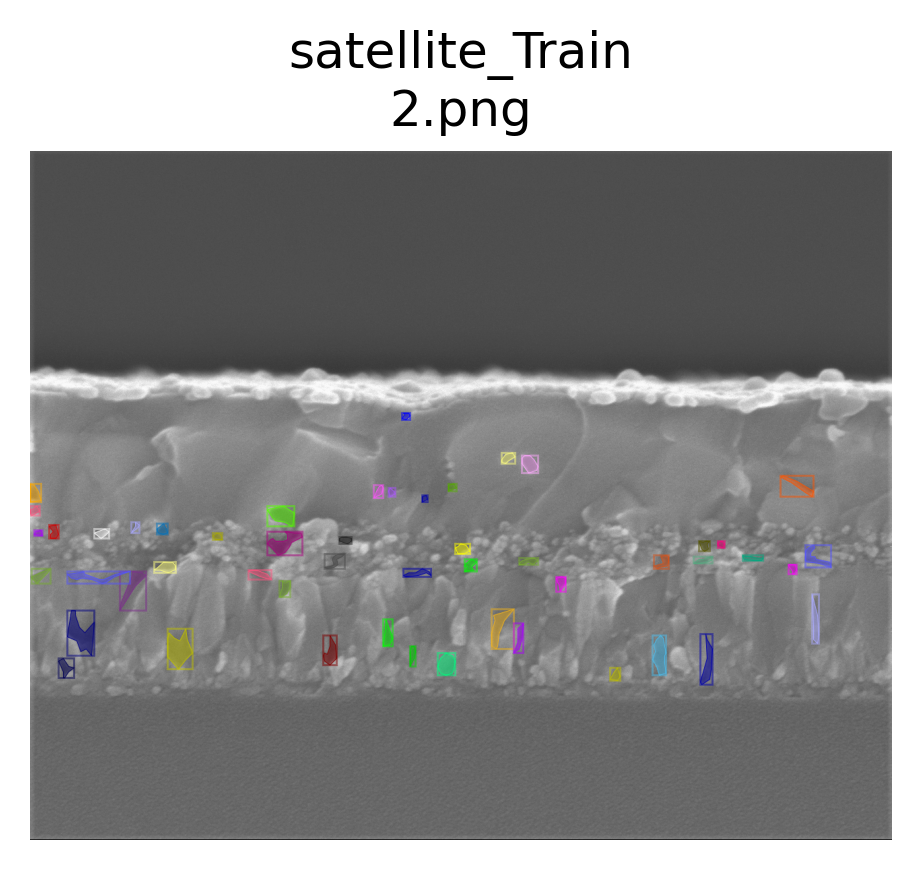

ddict info:
	path: SALAS_Rep/images/2.png
	num_instances: 51


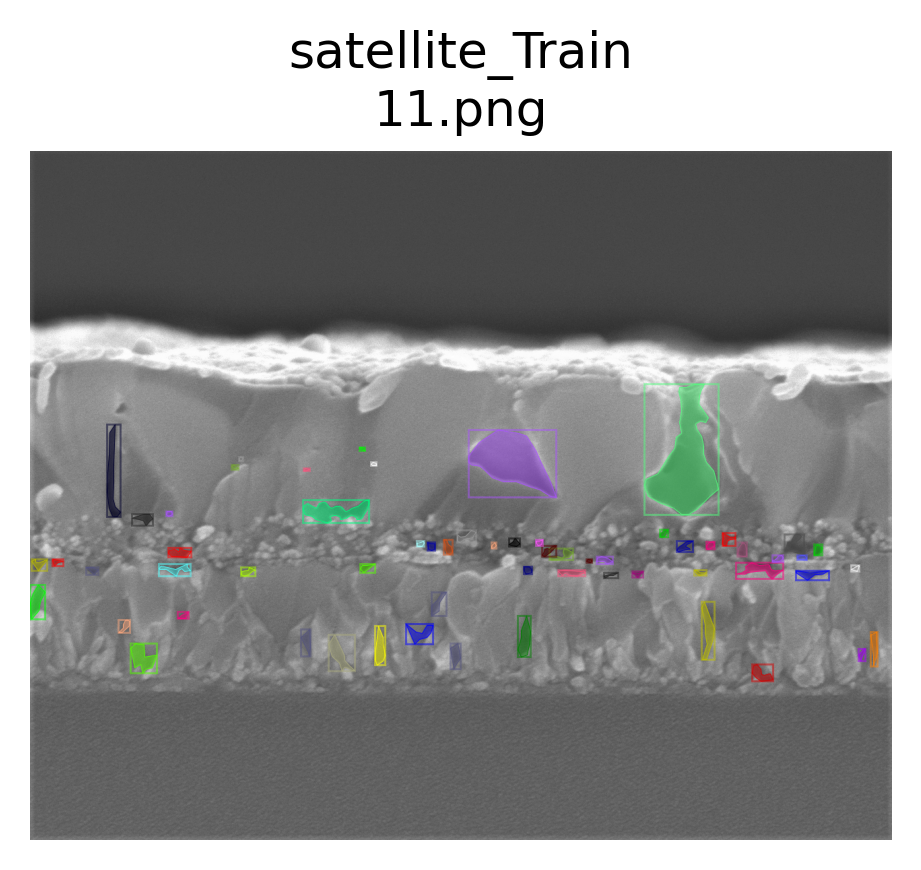

ddict info:
	path: SALAS_Rep/images/11.png
	num_instances: 61


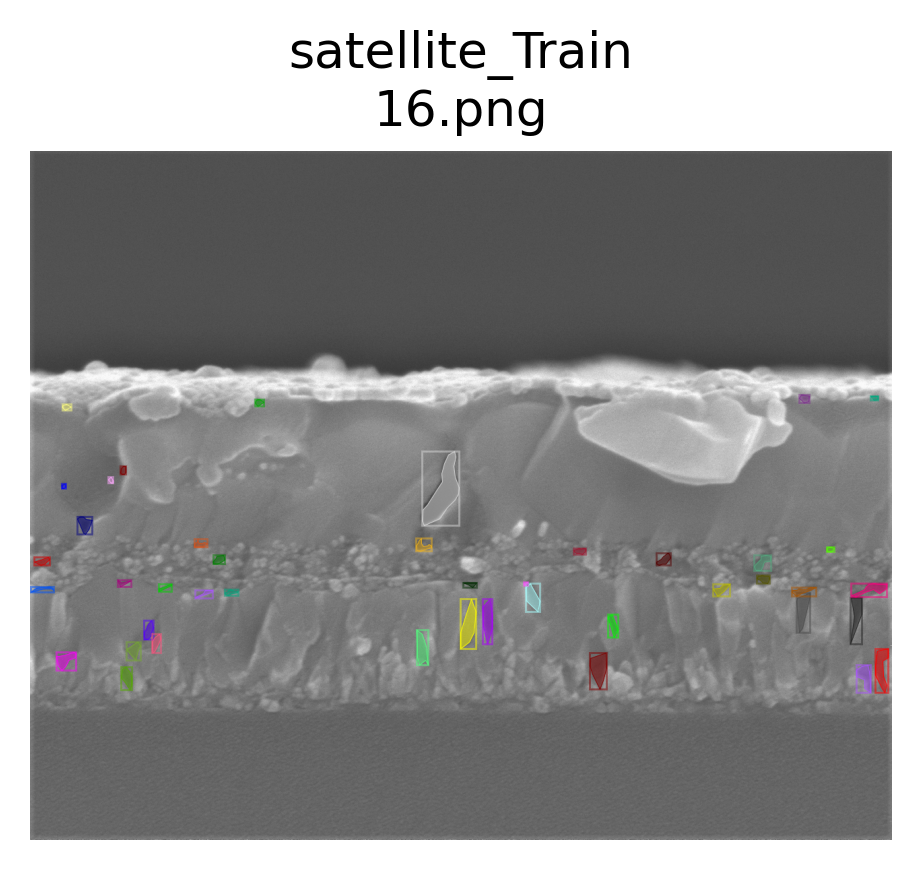

ddict info:
	path: SALAS_Rep/images/16.png
	num_instances: 43


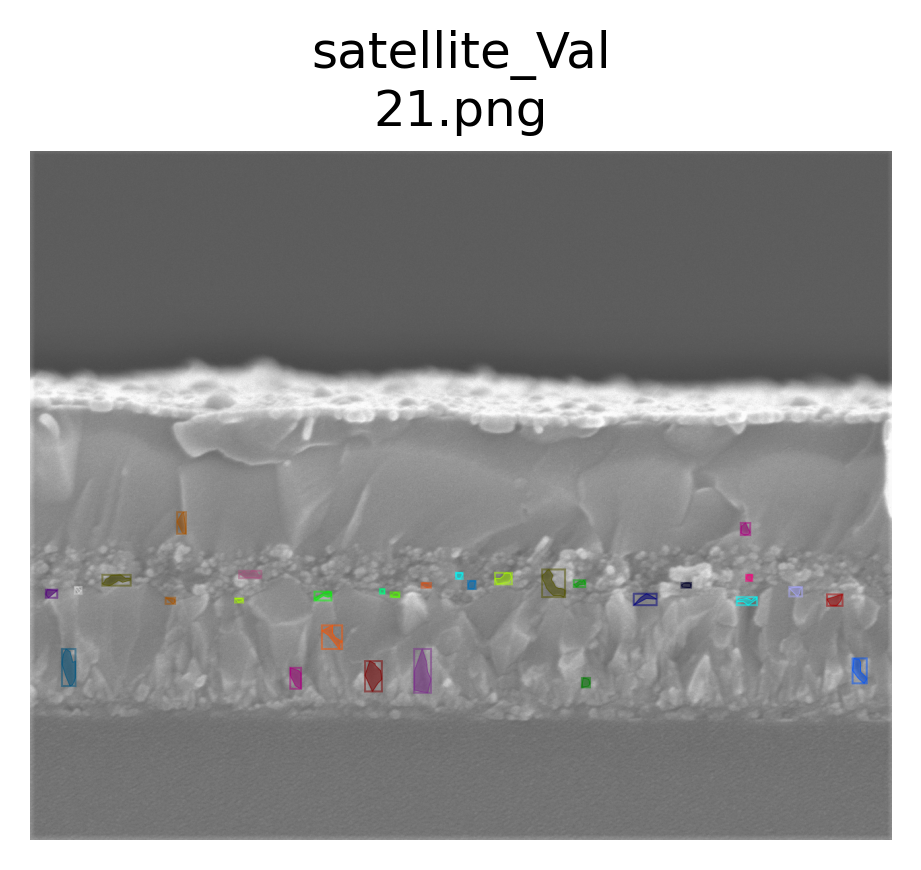

ddict info:
	path: SALAS_Rep/images/21.png
	num_instances: 30


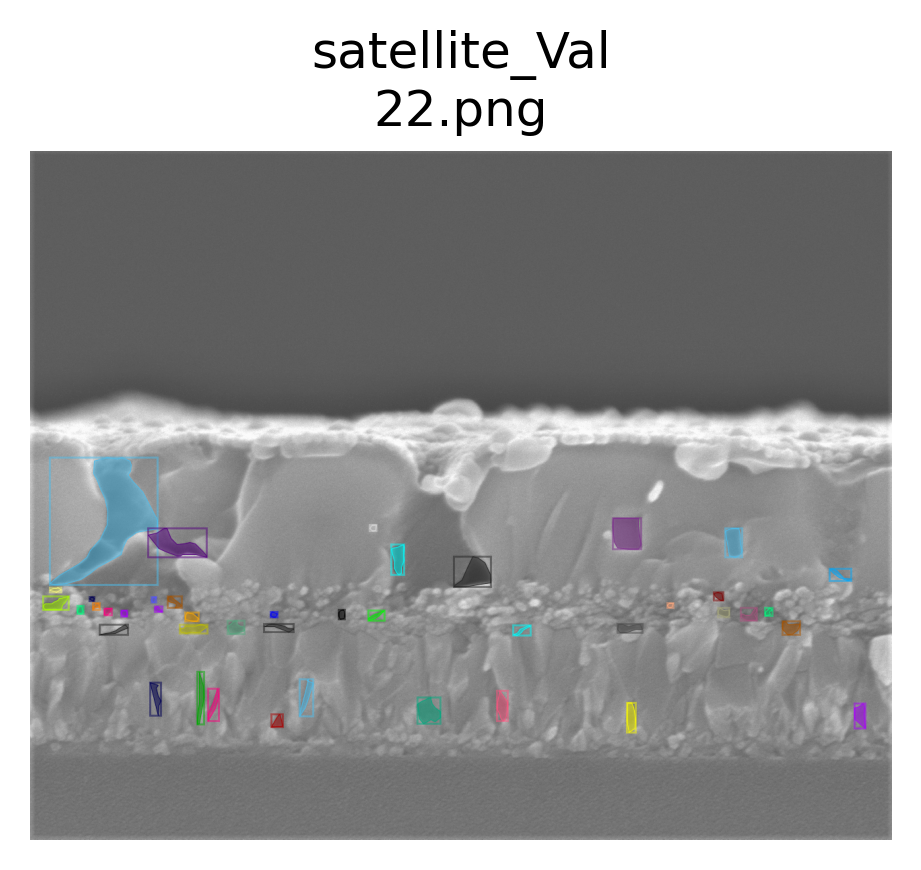

ddict info:
	path: SALAS_Rep/images/22.png
	num_instances: 43


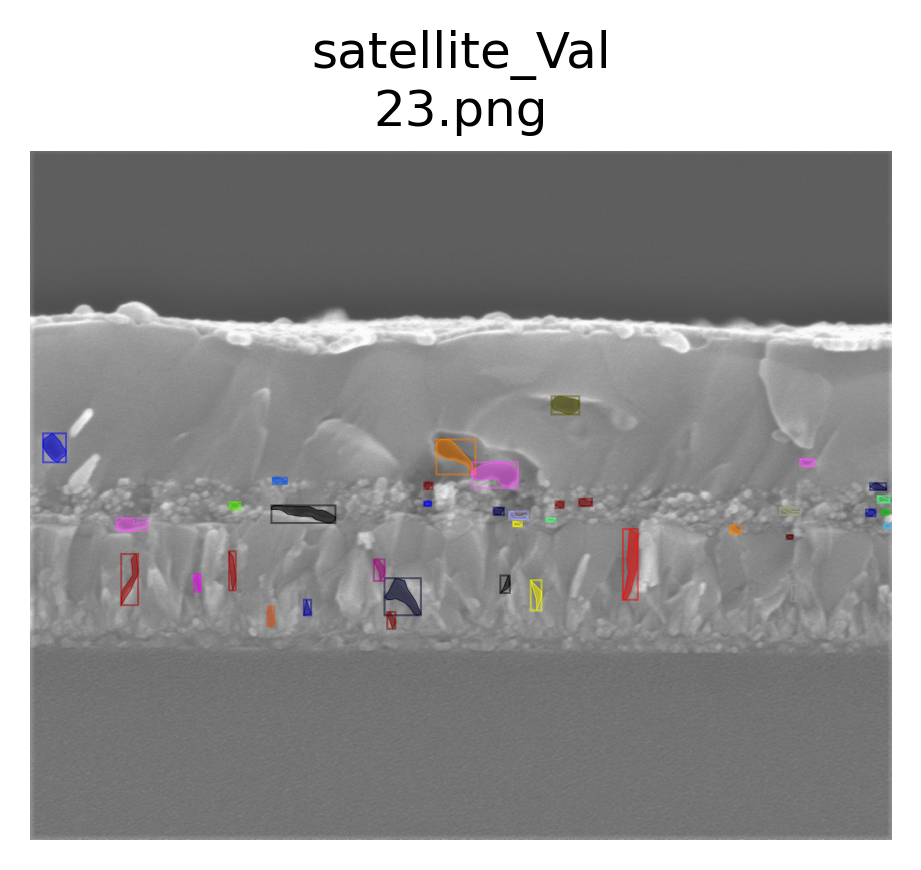

ddict info:
	path: SALAS_Rep/images/23.png
	num_instances: 37


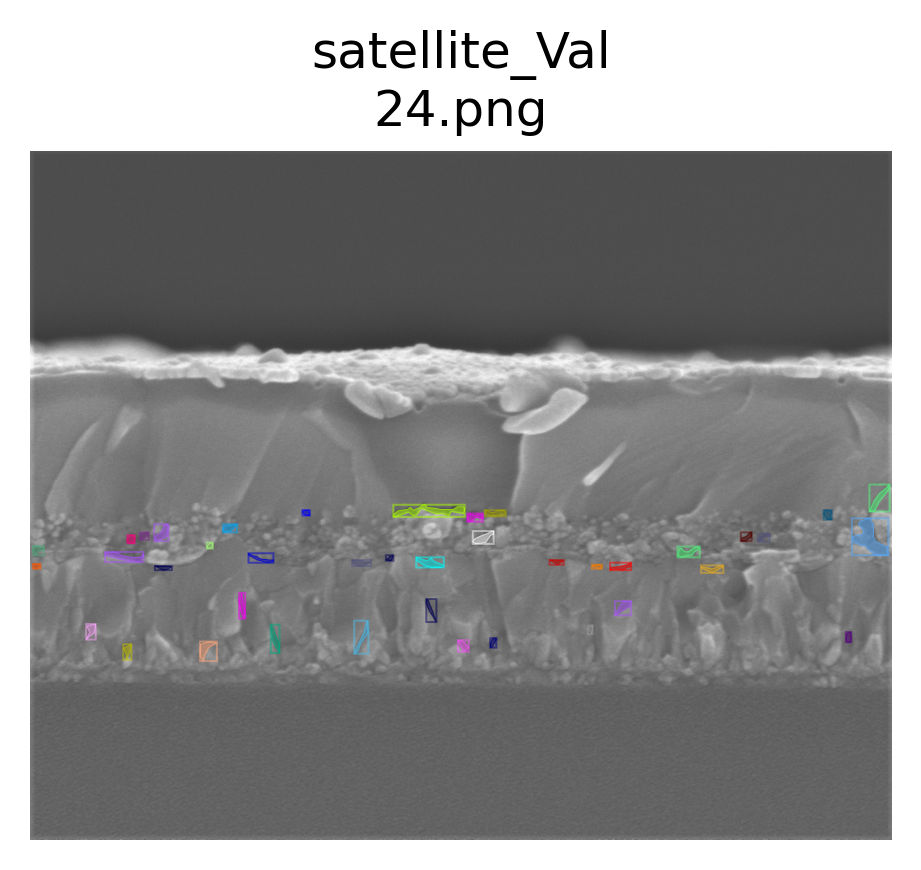

ddict info:
	path: SALAS_Rep/images/24.png
	num_instances: 40


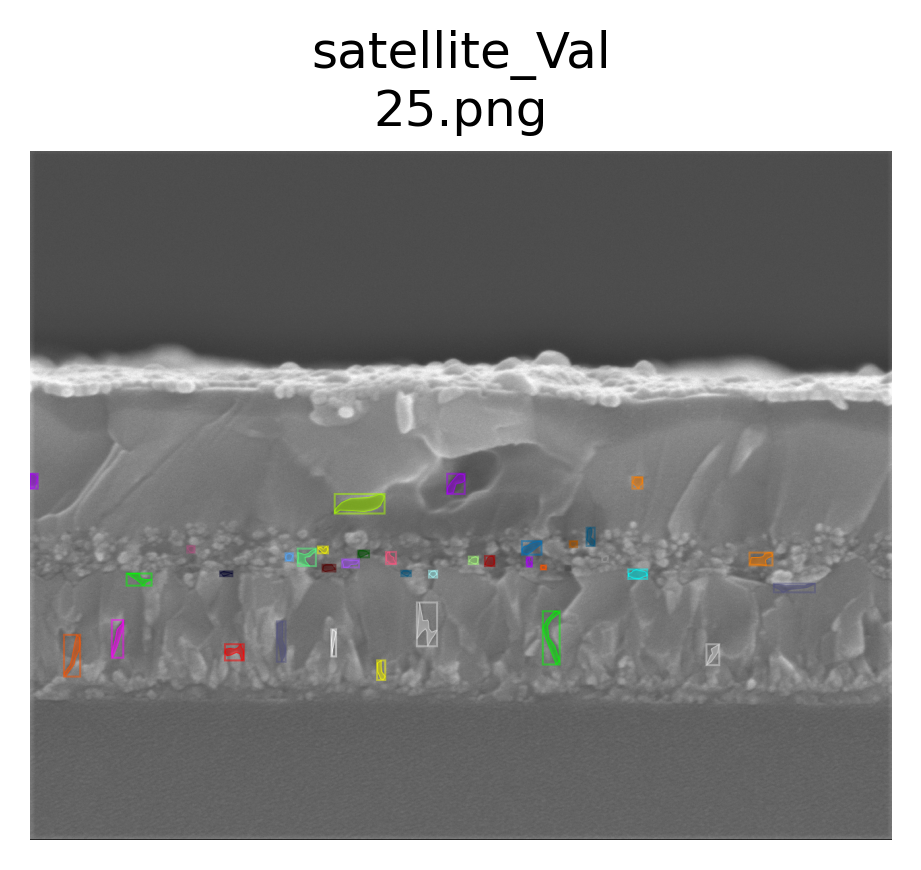

ddict info:
	path: SALAS_Rep/images/25.png
	num_instances: 37
Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


In [5]:
#print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})


#VERIFYING IMAGES LOADED PROPERLY

for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
    

for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

#MODEL CONFIGS
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.VALIDATION = (dataset_valid,)
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = CHECKPOINT_NUM  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = NUM_ITERATIONS  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path('weights', OUTPUT_FOLDER))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)


In [ ]:
pickle_folder = []
#CREATING PREDICTOR
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
for cycle in range(len(model_checkpoints)):
    cfg.MODEL.WEIGHTS = str(model_checkpoints[-cycle])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
    print("USING MODEL WEIGHT: " + str(model_checkpoints[-cycle]))
    predictor = DefaultPredictor(cfg)  # create predictor object
    print("Passed")

USING MODEL WEIGHT: weights/batch_temp1/model_0004999.pth


In [ ]:
path = 'SALAS_Rep/images'
#files = os.listdir(path)
img_names = []
for f in files:
    img_names.append(f.split('.')[0])
img_names = ['21', '22', '23', '24', '25']
img_names.sort()
results = []

for f in img_names:
    if len(f) > 1:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png') #Collects image name from list
        img = cv2.imread(str(img_path)) #Loads in image
        outs = predictor(img) #Creates Predictions
        export1 = export_anno.make_VIA_file(f +'.png', img_path, outs) #Converts predictions to VIA format
        export_anno.save_to_json('single_image_annotations/' + f +'_anno.json', export1) #Saves to JSON as specificed location
        outs = predictor(img) #The predictions were converted, so to visualize, they must be recalculated
        data_utils.format_outputs(img_path, dataset='test', pred=outs) #Converts Tensors to RLE format for easier vizualization
        results.append(visualize.display_ddicts(ddict=outs,  # predictions to display
                                     outpath=None, dataset='Test',  # don't save fi$
                                     gt=False,  # specifies format as model predict$
                                     img_path=img_path, # path to image
                                     suppress_labels=True, #hides class images
                                     summary=True))  #hides the end print statement
title = 'validation_output.pickle'
with open(title, 'wb') as f:
        pickle.dump(results, f)

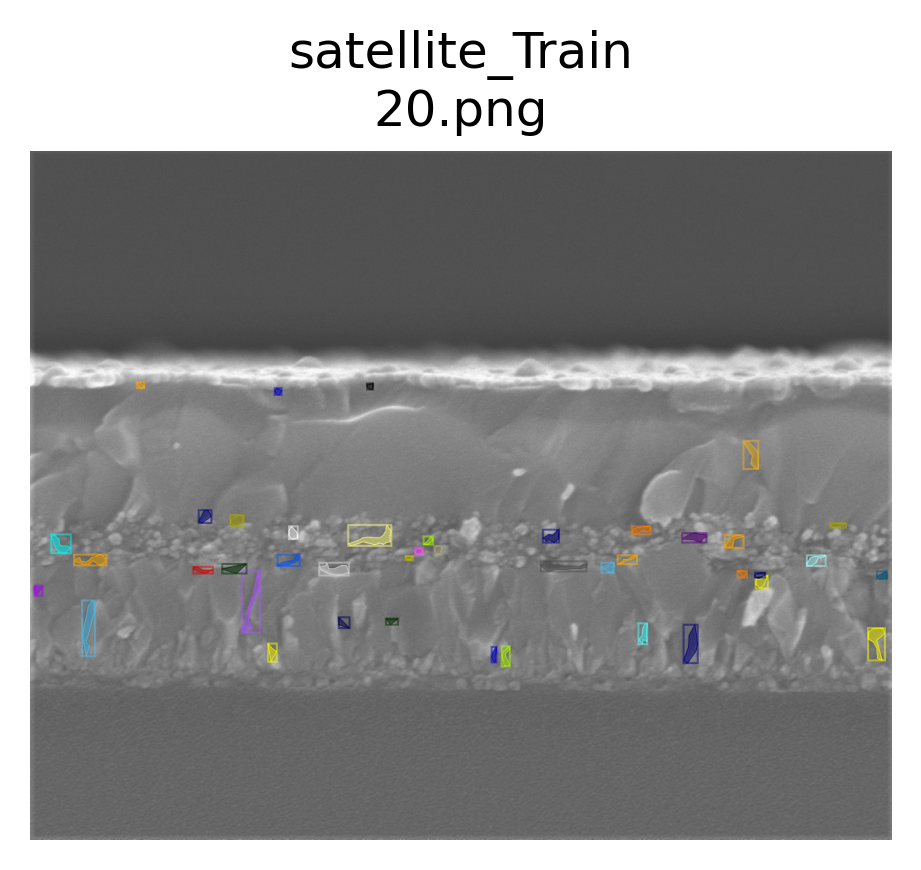

ddict info:
	path: SALAS_Rep/images/20.png
	num_instances: 42


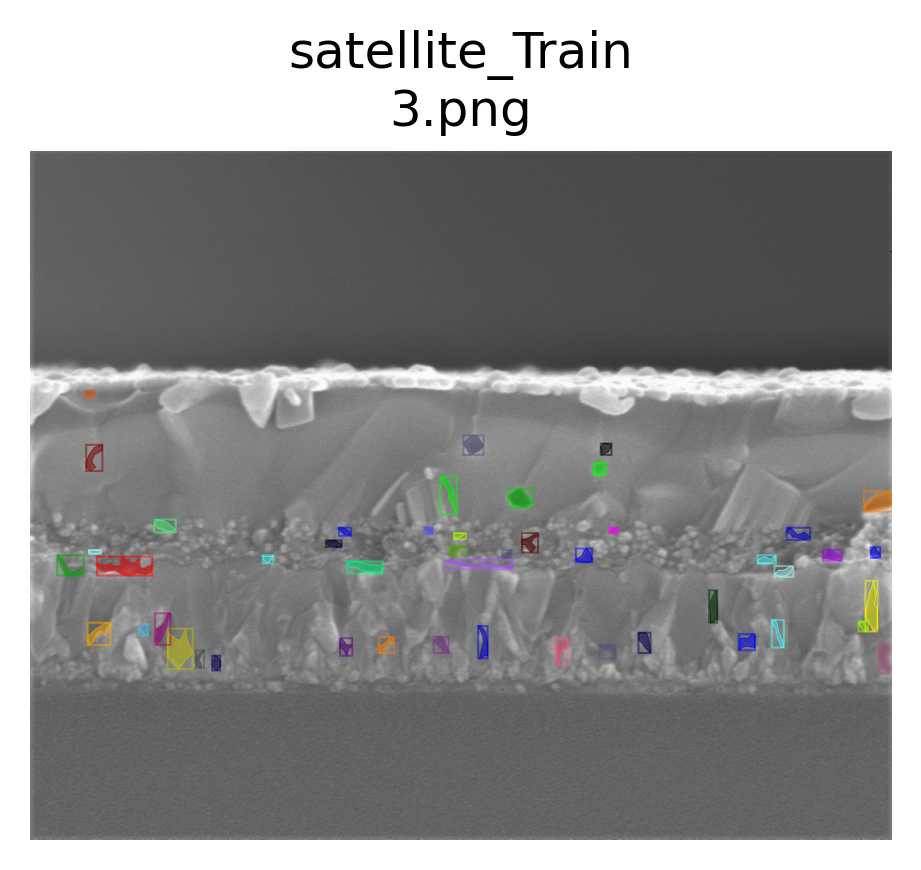

ddict info:
	path: SALAS_Rep/images/3.png
	num_instances: 48


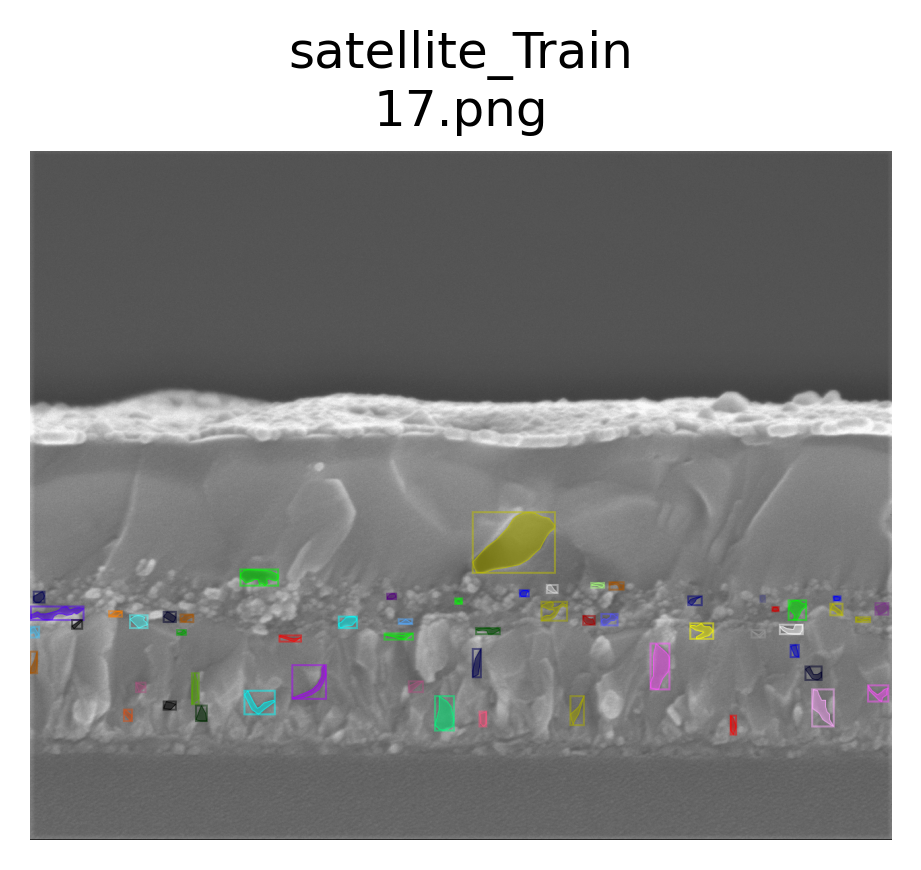

ddict info:
	path: SALAS_Rep/images/17.png
	num_instances: 55


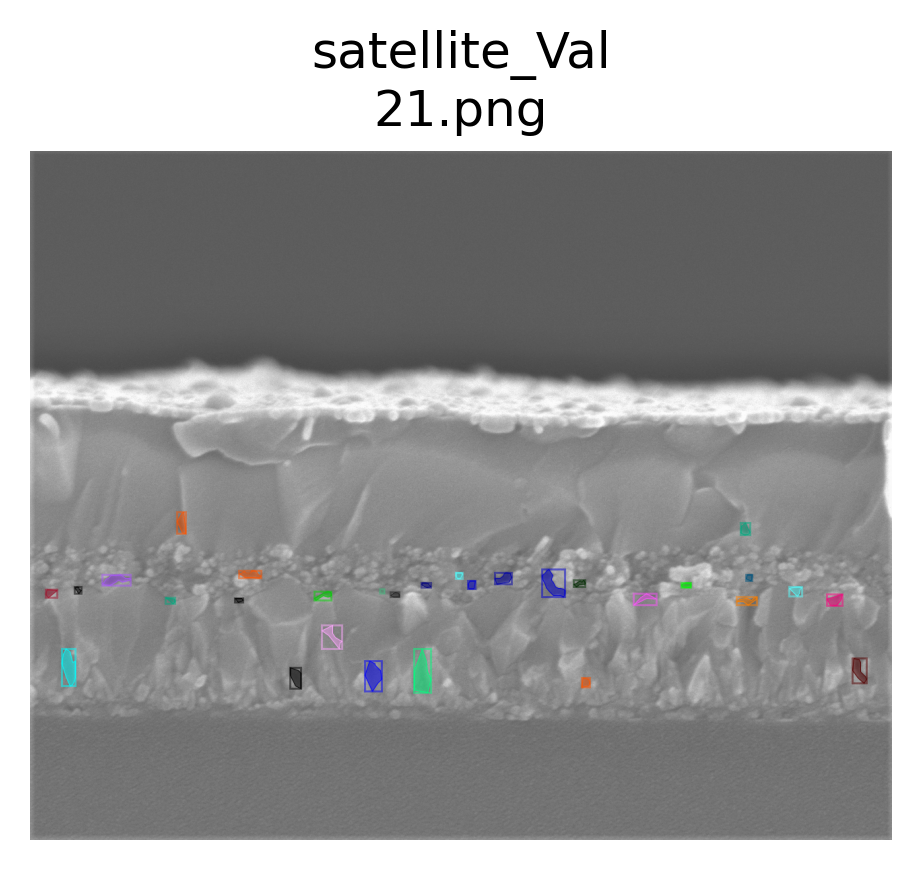

ddict info:
	path: SALAS_Rep/images/21.png
	num_instances: 30


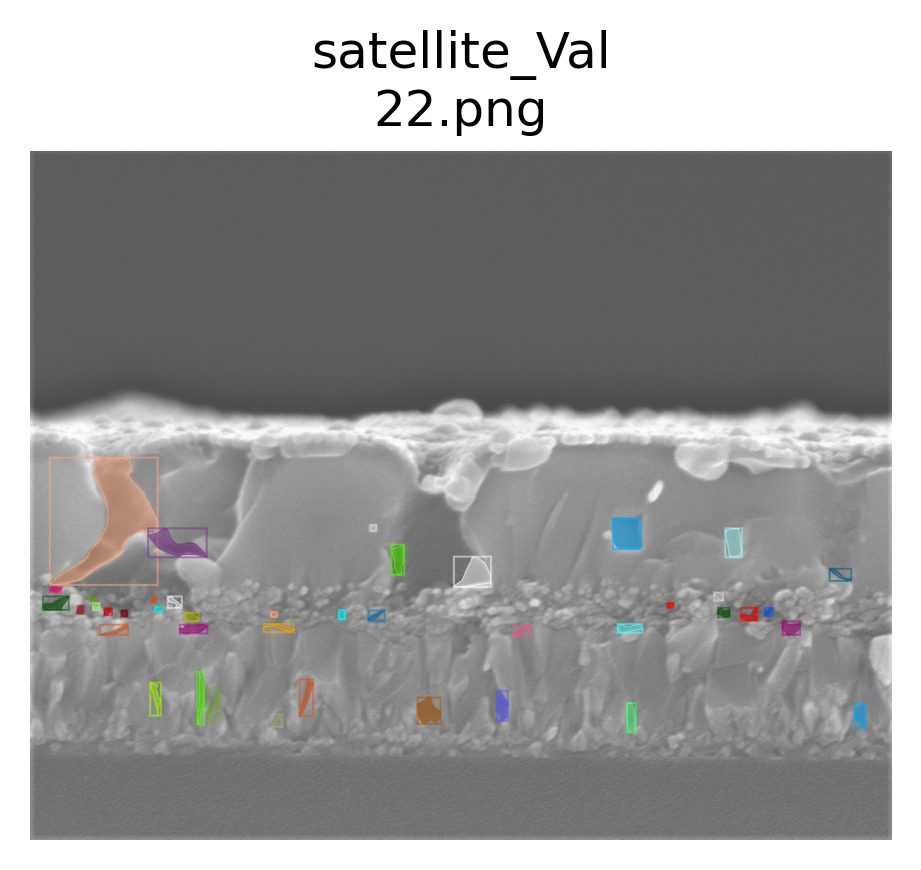

ddict info:
	path: SALAS_Rep/images/22.png
	num_instances: 43


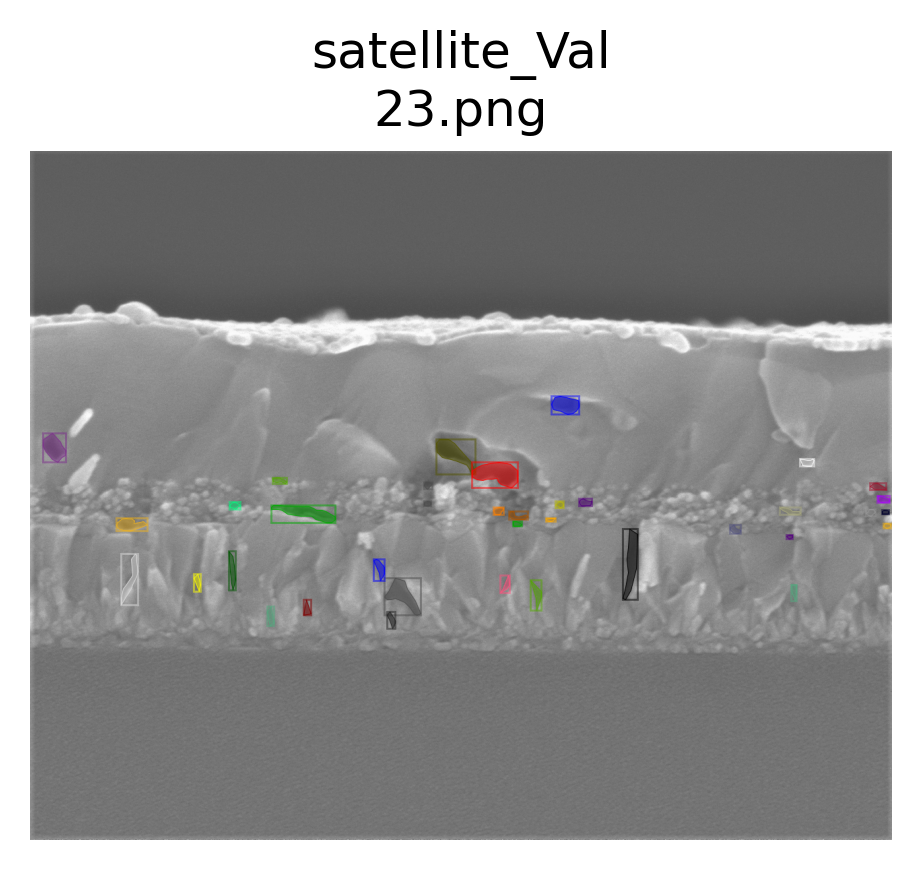

ddict info:
	path: SALAS_Rep/images/23.png
	num_instances: 37


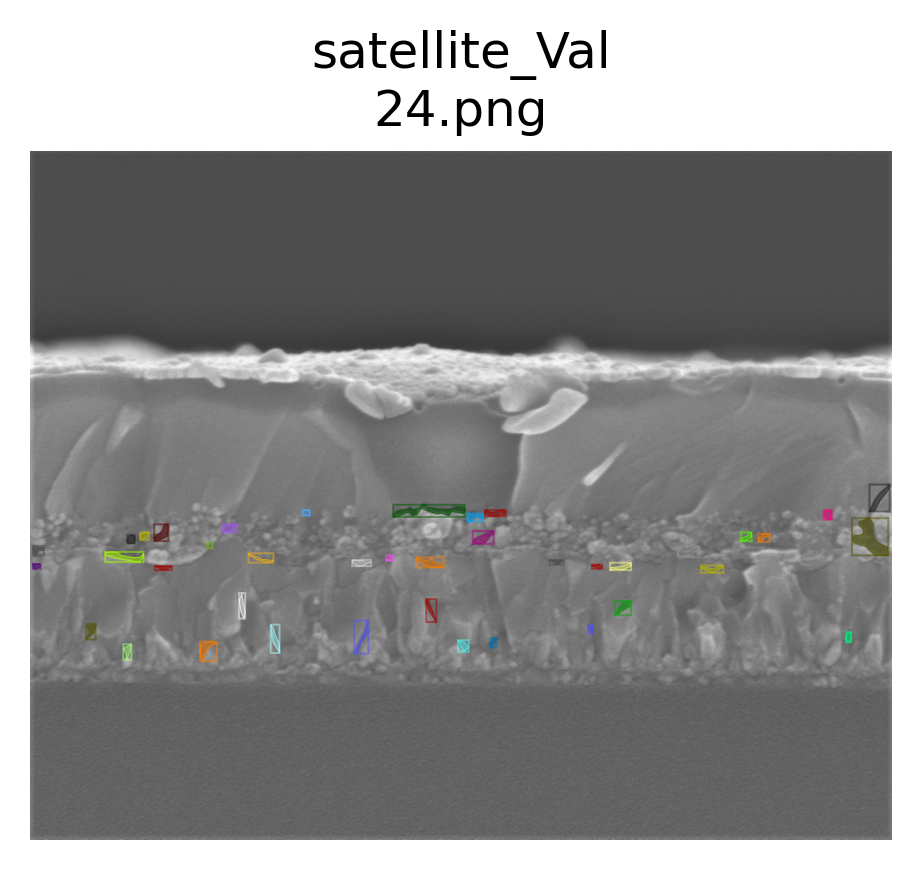

ddict info:
	path: SALAS_Rep/images/24.png
	num_instances: 40


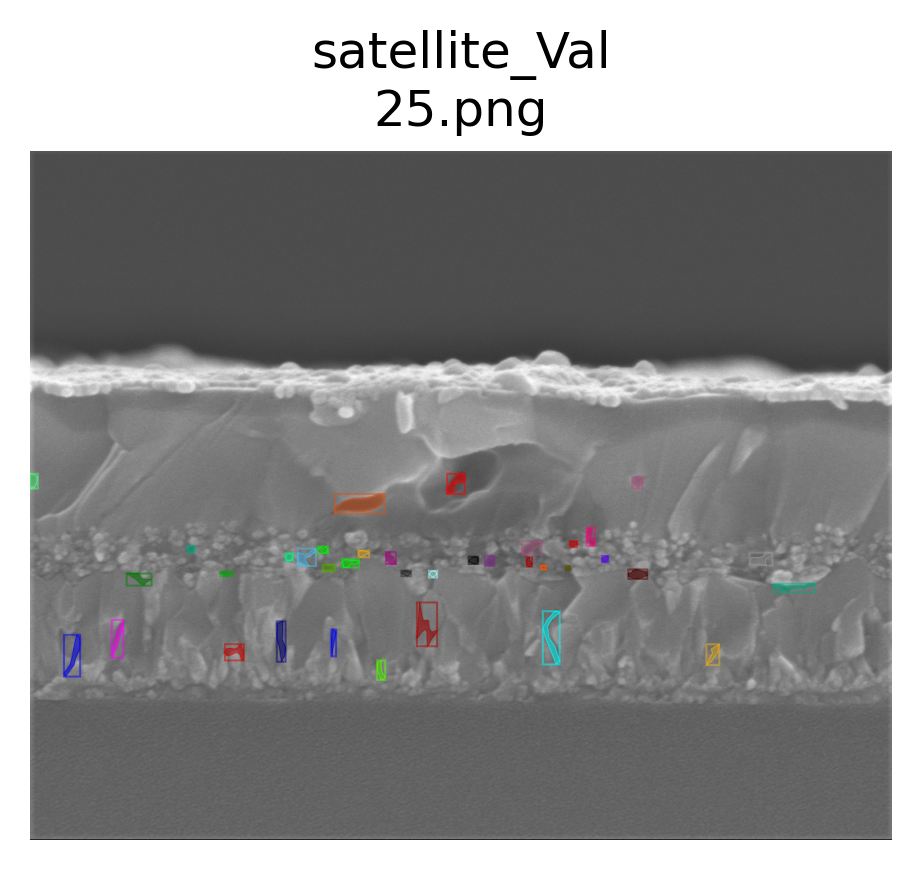

ddict info:
	path: SALAS_Rep/images/25.png
	num_instances: 37
Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
USING MODEL WEIGHT: weights/batch_temp1/model_0004999.pth


In [ ]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage
import skimage.io
import sys
import pandas as pd
import pycocotools.mask as RLE
import seaborn as sns


## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/tuning/'
sys.path.append(root)

from AMPIS import data_utils, visualize, analyze, export_anno
from AMPIS.applications import powder
from AMPIS.structures import InstanceSet
from AMPIS.visualize import display_iset

#CONSTANTS
#--------------------------------------------------------------
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
NUM_ITERATIONS = 5000
CHECKPOINT_NUM = 5000
NUM_CYCLES = 1
OUTPUT_FOLDER = 'batch_temp1'
LR = 0.001
WD = 0.0001
BB = 'ResNet50'
#--------------------------------------------------------------


##LOADING DATA
json_path_train = Path('SALAS_Rep', 'images', 'solar_trainingV2.json')  # path to training data
json_path_val = Path('SALAS_Rep', 'images', 'solar_validV2.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

## REGISTERING DATA

DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
#print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})


#VERIFYING IMAGES LOADED PROPERLY

for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
    

for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

#MODEL CONFIGS
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.VALIDATION = (dataset_valid,)
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = CHECKPOINT_NUM  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = NUM_ITERATIONS  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path('weights', OUTPUT_FOLDER))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
for cycle in range(len(model_checkpoints) - 1):
    cfg.MODEL.WEIGHTS = str(model_checkpoints[-cycle])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
    print("USING MODEL WEIGHT: " + str(model_checkpoints[-cycle]))
    predictor = DefaultPredictor(cfg)  # create predictor object

path = 'SALAS_Rep/images'
files = os.listdir(path)
img_names = []
'''for f in files:
    img_names.append(f.split('.')[0])'''
img_names = ['21', '22', '23', '24', '25']
img_names.sort()
for f in img_names:
    if len(f) > 1:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png') #Collects image name from list
        img = cv2.imread(str(img_path)) #Loads in image
        outs = predictor(img) #Creates Predictions
        export1 = export_anno.make_VIA_file(f +'.png', img_path, outs) #Converts predictions to VIA format
        export_anno.save_to_json('single_image_annotations/' + f +'_anno.json', export1) #Saves to JSON as specificed location
        outs = predictor(img) #The predictions were converted, so to visualize, they must be recalculated
        data_utils.format_outputs(img_path, dataset='test', pred=outs) #Converts Tensors to RLE format for easier vizualization
        visualize.display_ddicts(ddict=outs,  # predictions to display
                                     outpath=None, dataset='Test',  # don't save fi$
                                     gt=False,  # specifies format as model predict$
                                     img_path=img_path, # path to image
                                     suppress_labels=True, #hides class images
                                     summary=True)  #hides the end print statement

from PIL import Image 
import PIL
